In [ ]:
import re
import numpy as np
from matplotlib import pyplot as plt

from transformers import AutoProcessor

from datasets import load_dataset
import math
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import torch
import torch.utils.checkpoint
from torch import nn
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn

from transformers.cache_utils import Cache, StaticCache

from transformers.models.auto import AutoModel, AutoModelForCausalLM

os.environ["HF_TOKEN"] = (
    "**wdhfhufhd**"  # need a hugging face token to access paligemma model
)

In [2]:
!pip install einops


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
from einops import rearrange, reduce, repeat


dataset_id = "ThraggBilly/flickr30k_dataset"

model_id = "google/paligemma-3b-pt-224"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dtype = torch.bfloat16


batch_size = 2

learning_rate = 5e-5

In [4]:
!ls ../input

added_tokens.json		  preprocessor_config.json
config.json			  special_tokens_map.json
generation_config.json		  tokenizer.json
model-00001-of-00002.safetensors  tokenizer.model
model-00002-of-00002.safetensors  tokenizer_config.json
model.safetensors.index.json


In [5]:
processor = AutoProcessor.from_pretrained(model_id)
tokenizer = processor.tokenizer
feature_extractor = processor.image_processor

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [6]:
dataset = load_dataset(dataset_id, split="train")
dataset = dataset.train_test_split(test_size=0.15)

train_dataset = dataset["train"]
val_test_dataset = dataset["test"].train_test_split(test_size=0.2)

val_dataset = val_test_dataset["train"]
test_dataset = val_test_dataset["test"]

README.md:   0%|          | 0.00/406 [00:00<?, ?B/s]

(…)-00000-of-00009-4e80642ba23a935e.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)-00001-of-00009-af4656848a2d23ea.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

(…)-00002-of-00009-a8ec1c104f89643e.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

(…)-00003-of-00009-e3415d2640528a98.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)-00004-of-00009-8d248e70d694ad63.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00005-of-00009-518d1fa058e07914.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

(…)-00006-of-00009-fcdffb0dbec40bd4.parquet:   0%|          | 0.00/527M [00:00<?, ?B/s]

(…)-00007-of-00009-080db2a624e679aa.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

(…)-00008-of-00009-fcf7cc9010a04a6d.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31783 [00:00<?, ? examples/s]

In [ ]:
image_seq_length = 256  #
IMAGE_TOKEN = "<image>"


# tokenizer.bos_token
def build_string_from_input(
    prompt,
    bos_token=tokenizer.bos_token,
    image_seq_len=image_seq_length,
    image_token=IMAGE_TOKEN,
    num_images=1,
):
    return f"{image_token * image_seq_len * num_images}{bos_token}{prompt}\n"


def get_model_inputs(
    prompt,
    image,
    suffix=None,
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    max_length=296,
):

    return_token_type_ids = False

    if suffix:
        suffix = [sfx + tokenizer.eos_token for sfx in suffix]
        return_token_type_ids = True

    input_string = [build_string_from_input(text) for text in prompt]
    return_token_type_ids = True if suffix is not None else False
    inputs = tokenizer(
        input_string,
        text_pair=suffix,
        return_token_type_ids=return_token_type_ids,
        padding="max_length",
        add_special_tokens=False,
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )

    if return_token_type_ids:
        labels = inputs["input_ids"].masked_fill(inputs["token_type_ids"] == 0, -100)
        inputs["labels"] = labels

    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values

    inputs = {"pixel_values": pixel_values, **inputs}

    return inputs

In [ ]:
def move_inputs_to_device(model_inputs: dict, device: str):
    model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
    return model_inputs


def collate_train_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Caption the image." for _ in examples]
    suffix = [example["text"] for example in examples]

    inputs = get_model_inputs(image=images, prompt=prompt, suffix=suffix)

    inputs = move_inputs_to_device(inputs, device)
    inputs["pixel_values"] = inputs["pixel_values"].to(dtype)
    return inputs


def collate_test_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Caption the image." for _ in examples]

    inputs = get_model_inputs(
        image=images,
        prompt=prompt,
    )

    inputs = move_inputs_to_device(inputs, device)
    inputs["pixel_values"] = inputs["pixel_values"].to(dtype)
    return inputs

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
from transformers.configuration_utils import PretrainedConfig
from typing import Optional, Tuple
import torch
import torch.nn as nn


class SiglipVisionConfig:

    def __init__(
        self,
        hidden_size=768,
        intermediate_size=3072,
        num_hidden_layers=12,
        num_attention_heads=12,
        num_channels=3,
        image_size=224,
        patch_size=16,
        layer_norm_eps=1e-6,
        attention_dropout=0.0,
        num_image_tokens: int = None,
        **kwargs,
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.num_channels = num_channels
        self.patch_size = patch_size
        self.image_size = image_size
        self.attention_dropout = attention_dropout
        self.layer_norm_eps = layer_norm_eps
        self.num_image_tokens = num_image_tokens


class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid",  # This indicates no padding is added
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False,
        )

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        _, _, height, width = (
            pixel_values.shape
        )  # [Batch_Size, Channels, Height, Width]
        # Convolve the `patch_size` kernel over the image, with no overlapping patches since the stride is equal to the kernel size
        # The output of the convolution will have shape [Batch_Size, Embed_Dim, Num_Patches_H, Num_Patches_W]

        patch_embeds = self.patch_embedding(pixel_values)

        embeddings = rearrange(patch_embeds, "b d h w -> b (h w) d")

        embeddings = embeddings + self.position_embedding(self.position_ids)

        return embeddings


class SiglipAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5  #  1 / sqrt(self.head_dim)
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:

        batch_size, seq_len, _ = hidden_states.size()

        query_states = self.q_proj(hidden_states)

        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)

        query_states = rearrange(query_states, "b l (h d) -> b h l d", d=self.head_dim)
        key_states = rearrange(key_states, "b l (h d) -> b h l d", d=self.head_dim)
        value_states = rearrange(value_states, "b l (h d) -> b h l d", d=self.head_dim)

        attn_weights = (
            torch.einsum("b h i d , b h j d -> b h i j", query_states, key_states)
            * self.scale
        )

        attn_weights = nn.functional.softmax(
            attn_weights, dim=-1, dtype=torch.float32
        ).to(query_states.dtype)

        attn_output = torch.einsum(
            "b h i j , b h j d -> b h i d", attn_weights, value_states
        )

        attn_output = rearrange(attn_output, "b h l d -> b l (h d)")
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


class SiglipMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Intermediate_Size]
        hidden_states = self.fc1(hidden_states)
        # hidden_states: [Batch_Size, Num_Patches, Intermediate_Size]
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        # [Batch_Size, Num_Patches, Intermediate_Size] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.fc2(hidden_states)

        return hidden_states


class SiglipEncoderLayer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    # Ignore copy
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # residual: [Batch_Size, Num_Patches, Embed_Dim]
        residual = hidden_states
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.layer_norm1(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states, _ = self.self_attn(hidden_states=hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = residual + hidden_states
        # residual: [Batch_Size, Num_Patches, Embed_Dim]
        residual = hidden_states
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.layer_norm2(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.mlp(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = residual + hidden_states

        return hidden_states


class SiglipEncoder(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList(
            [SiglipEncoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    # Ignore copy
    def forward(self, inputs_embeds: torch.Tensor) -> torch.Tensor:
        # inputs_embeds: [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = inputs_embeds

        for encoder_layer in self.layers:
            # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
            hidden_states = encoder_layer(hidden_states)

        return hidden_states


class SiglipVisionTransformer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size

        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        # pixel_values: [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.embeddings(pixel_values)

        last_hidden_state = self.encoder(inputs_embeds=hidden_states)

        last_hidden_state = self.post_layernorm(last_hidden_state)

        return last_hidden_state


@dataclass
class VisionOutput:
    last_hidden_state: torch.FloatTensor = None


class SiglipVisionModel(nn.Module):

    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)

    def forward(self, pixel_values) -> Tuple:
        # [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        return VisionOutput(
            last_hidden_state=self.vision_model(pixel_values=pixel_values)
        )


class GemmaConfig:

    def __init__(
        self,
        vocab_size,
        hidden_size,
        intermediate_size,
        num_hidden_layers,
        num_attention_heads,
        num_key_value_heads,
        head_dim=256,
        max_position_embeddings=8192,
        rms_norm_eps=1e-6,
        rope_theta=10000.0,
        attention_bias=False,
        attention_dropout=0.0,
        pad_token_id=None,
        **kwargs,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.head_dim = head_dim
        self.num_key_value_heads = num_key_value_heads
        self.rms_norm_eps = rms_norm_eps
        self.rope_theta = rope_theta
        self.attention_bias = attention_bias
        self.attention_dropout = attention_dropout
        self.pad_token_id = pad_token_id


class PaliGemmaConfig:

    def __init__(
        self,
        vision_config=None,
        text_config=None,
        ignore_index=-100,
        image_token_index=256000,
        vocab_size=257152,
        projection_dim=2048,
        hidden_size=2048,
        pad_token_id=None,
        **kwargs,
    ):
        super().__init__()
        self.ignore_index = ignore_index
        self.image_token_index = image_token_index
        self.vocab_size = vocab_size
        self.projection_dim = projection_dim
        self.hidden_size = hidden_size
        self.vision_config = vision_config
        self.is_encoder_decoder = False
        self.pad_token_id = pad_token_id

        self.vision_config = SiglipVisionConfig(**vision_config)
        self.text_config = text_config

        self.text_config = GemmaConfig(**text_config, pad_token_id=pad_token_id)
        self.vocab_size = self.text_config.vocab_size

        self.text_config.num_image_tokens = (
            self.vision_config.image_size // self.vision_config.patch_size
        ) ** 2
        self.vision_config.projection_dim = projection_dim

In [11]:
from typing import Optional, Tuple
import torch
import torch.nn as nn

In [ ]:
class GemmaRMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.zeros(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float())

        output = output * (1.0 + self.weight.float())
        return output.type_as(x)


class GemmaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim  # it is set to the head_dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base

        # Calculate the theta according to the formula theta_i = base^(2i/dim) where i = 0, 1, 2, ..., dim // 2
        inv_freq = 1.0 / (
            self.base
            ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim)
        )
        self.register_buffer("inv_freq", tensor=inv_freq, persistent=False)

    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        self.inv_freq.to(x.device)
        # Copy the inv_freq tensor for batch in the sequence
        # inv_freq_expanded: [Batch_Size, Head_Dim // 2, 1]
        inv_freq_expanded = (
            self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        )
        # position_ids_expanded: [Batch_Size, 1, Seq_Len]

        position_ids_expanded = position_ids[:, None, :].float()
        device_type = x.device.type
        device_type = (
            device_type
            if isinstance(device_type, str) and device_type != "mps"
            else "cpu"
        )
        with torch.autocast(device_type=device_type, enabled=False):
            # Multiply each theta by the position (which is the argument of the sin and cos functions)
            # freqs: [Batch_Size, Head_Dim // 2, 1] @ [Batch_Size, 1, Seq_Len] --> [Batch_Size, Seq_Len, Head_Dim // 2]
            freqs = (
                inv_freq_expanded.float() @ position_ids_expanded.float()
            ).transpose(1, 2)
            # emb: [Batch_Size, Seq_Len, Head_Dim]
            emb = torch.cat((freqs, freqs), dim=-1)
            # cos, sin: [Batch_Size, Seq_Len, Head_Dim]
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)


def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)  # Add the head dimension
    sin = sin.unsqueeze(unsqueeze_dim)  # Add the head dimension
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


class GemmaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)

    def forward(self, x):

        return self.down_proj(
            nn.functional.gelu(self.gate_proj(x), approximate="tanh") * self.up_proj(x)
        )

In [ ]:
def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(
        batch, num_key_value_heads, n_rep, slen, head_dim
    )
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


class GemmaAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: GemmaConfig, layer_idx: Optional[int] = None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        if layer_idx is None:
            logger.warning_once(
                f"Instantiating {self.__class__.__name__} without passing a `layer_idx` is not recommended and will "
                "lead to errors during the forward call if caching is used. Please make sure to provide a `layer_idx` "
                "when creating this class."
            )

        self.attention_dropout = config.attention_dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = config.head_dim
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.max_position_embeddings = config.max_position_embeddings
        self.rope_theta = config.rope_theta
        self.is_causal = True
        self.scaling = 1 / math.sqrt(config.head_dim)

        if self.hidden_size % self.num_heads != 0:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )

        self.q_proj = nn.Linear(
            self.hidden_size, self.num_heads * self.head_dim, bias=config.attention_bias
        )
        self.k_proj = nn.Linear(
            self.hidden_size,
            self.num_key_value_heads * self.head_dim,
            bias=config.attention_bias,
        )
        self.v_proj = nn.Linear(
            self.hidden_size,
            self.num_key_value_heads * self.head_dim,
            bias=config.attention_bias,
        )
        self.o_proj = nn.Linear(
            self.num_heads * self.head_dim, self.hidden_size, bias=config.attention_bias
        )
        self.rotary_emb = GemmaRotaryEmbedding(
            self.head_dim,
            max_position_embeddings=self.max_position_embeddings,
            base=self.rope_theta,
        )

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        use_cache: bool = False,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        bsz, q_len, _ = hidden_states.size()

        query_states = self.q_proj(hidden_states)
        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)

        query_states = rearrange(query_states, "b l (h d) -> b h l d", d=self.head_dim)
        key_states = rearrange(key_states, "b l (h d) -> b h l d", d=self.head_dim)
        value_states = rearrange(value_states, "b l (h d) -> b h l d", d=self.head_dim)

        cos, sin = self.rotary_emb(value_states, position_ids)
        query_states, key_states = apply_rotary_pos_emb(
            query_states, key_states, cos, sin
        )

        if past_key_value is not None:
            # sin and cos are specific to RoPE models; cache_position needed for the static cache
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_value.update(
                key_states, value_states, self.layer_idx, cache_kwargs
            )

        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        attn_weights = (
            torch.einsum("b h i d , b h j d -> b h i j", query_states, key_states)
            * self.scaling
        )

        if attention_mask is not None:  # no matter the length, we just slice it
            causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
            attn_weights = attn_weights + causal_mask

        # upcast attention to fp32
        attn_weights = nn.functional.softmax(
            attn_weights, dim=-1, dtype=torch.float32
        ).to(query_states.dtype)
        attn_weights = nn.functional.dropout(
            attn_weights, p=self.attention_dropout, training=self.training
        )
        attn_output = torch.einsum(
            "b h i j , b h j d -> b h i d", attn_weights, value_states
        )

        if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = rearrange(attn_output, "b h l d -> b l (h d)")

        attn_output = self.o_proj(attn_output)

        return attn_output, past_key_value

In [ ]:
class GemmaDecoderLayer(nn.Module):
    def __init__(self, config: GemmaConfig, layer_idx: int):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.self_attn = GemmaAttention(config=config, layer_idx=layer_idx)
        self.mlp = GemmaMLP(config)
        self.input_layernorm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = GemmaRMSNorm(
            config.hidden_size, eps=config.rms_norm_eps
        )

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        use_cache: Optional[bool] = False,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Tuple[
        torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]
    ]:

        residual = hidden_states

        hidden_states = self.input_layernorm(hidden_states)

        # Self Attention
        hidden_states, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            use_cache=use_cache,
            cache_position=cache_position,
        )
        hidden_states = residual + hidden_states

        # Fully Connected
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if use_cache:
            outputs += (present_key_value,)

        return outputs

In [ ]:
@dataclass
class GemmaOutput:
    last_hidden_state: torch.FloatTensor = None
    past_key_values: Optional[Union[List[torch.FloatTensor], Cache]] = None


class GemmaModel(nn.Module):
    def __init__(self, config: GemmaConfig):
        super().__init__()
        self.padding_idx = config.pad_token_id
        self.vocab_size = config.vocab_size
        self.config = config

        self.embed_tokens = nn.Embedding(
            config.vocab_size, config.hidden_size, self.padding_idx
        )
        self.layers = nn.ModuleList(
            [
                GemmaDecoderLayer(config, layer_idx)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )
        self.norm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.gradient_checkpointing = False

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> GemmaOutput:

        use_cache = use_cache if use_cache is not None else False
        #         return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if (input_ids is None) ^ (inputs_embeds is not None):
            raise ValueError(
                "You must specify exactly one of input_ids or inputs_embeds"
            )

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids)

        if cache_position is None:
            past_seen_tokens = (
                past_key_values.get_seq_length() if past_key_values is not None else 0
            )
            cache_position = torch.arange(
                past_seen_tokens,
                past_seen_tokens + inputs_embeds.shape[1],
                device=inputs_embeds.device,
            )

        if position_ids is None:
            position_ids = cache_position.unsqueeze(0)

        causal_mask = attention_mask
        hidden_states = inputs_embeds

        normalizer = torch.tensor(
            self.config.hidden_size**0.5, dtype=hidden_states.dtype
        )
        hidden_states = hidden_states * normalizer

        # decoder layers

        next_decoder_cache = None

        for decoder_layer in self.layers:

            layer_outputs = decoder_layer(
                hidden_states,
                attention_mask=causal_mask,
                position_ids=position_ids,
                past_key_value=past_key_values,
                use_cache=use_cache,
                cache_position=cache_position,
            )

            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache = layer_outputs[1]

        hidden_states = self.norm(hidden_states)

        next_cache = next_decoder_cache if use_cache else None

        return GemmaOutput(last_hidden_state=hidden_states, past_key_values=next_cache)

In [ ]:
@dataclass
class GemmaCausalLMOutput:
    logits: torch.FloatTensor = None
    past_key_values: Optional[Union[List[torch.FloatTensor], Cache]] = None


class GemmaForCausalLM(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.model = GemmaModel(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    def tie_weights(self):
        self.lm_head.weight = self.model.embed_tokens.weight

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Union[Cache, List[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> GemmaCausalLMOutput:
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            cache_position=cache_position,
        )

        hidden_states = outputs.last_hidden_state
        logits = self.lm_head(hidden_states)

        return GemmaCausalLMOutput(
            logits=logits, past_key_values=outputs.past_key_values
        )

In [ ]:
@dataclass
class PaliGemmaCausalLMOutput:

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    past_key_values: Optional[Union[List[torch.FloatTensor], Cache]] = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None
    image_hidden_states: Optional[torch.FloatTensor] = None


class PaliGemmaMultiModalProjector(nn.Module):
    def __init__(self, config: PaliGemmaConfig):
        super().__init__()
        self.linear = nn.Linear(
            config.vision_config.hidden_size,
            config.vision_config.projection_dim,
            bias=True,
        )

    def forward(self, image_features):
        hidden_states = self.linear(image_features)

        return hidden_states


class PaliGemmaForConditionalGeneration(nn.Module):
    def __init__(self, config: PaliGemmaConfig):
        super().__init__()
        self.vision_tower = SiglipVisionModel(config.vision_config)
        self.multi_modal_projector = PaliGemmaMultiModalProjector(config)
        self.vocab_size = config.text_config.vocab_size
        self.config = config

        language_model = GemmaForCausalLM(config.text_config)

        self.language_model = language_model

        self.pad_token_id = (
            config.pad_token_id if config.pad_token_id is not None else -1
        )

    def tie_weights(self):
        return self.language_model.tie_weights()

    def _update_causal_mask(
        self,
        attention_mask,
        token_type_ids,
        inputs_embeds,
        past_key_values,
        cache_position,
        is_training: bool = False,
    ):
        if attention_mask is not None and attention_mask.dim() == 4:
            # mask comes already in inverted form and requires no inversion or slicing.
            return attention_mask

        using_static_cache = isinstance(past_key_values, StaticCache)
        dtype = inputs_embeds.dtype
        min_dtype = torch.finfo(dtype).min
        sequence_length = inputs_embeds.shape[1]
        if using_static_cache:
            target_length = past_key_values.get_max_length()
        else:
            target_length = attention_mask.shape[-1]

        causal_mask = torch.full(
            (sequence_length, target_length),
            fill_value=min_dtype,
            dtype=dtype,
            device=cache_position.device,
        )
        # Causal diagonal mask only if training, otherwise attend to the whole prefix. Training-specific attn for prefix is handled below
        if sequence_length != 1:
            if is_training:
                causal_mask = torch.triu(causal_mask, diagonal=1)
            else:
                causal_mask[:, :sequence_length] = 0.0

        causal_mask *= torch.arange(
            target_length, device=cache_position.device
        ) > cache_position.reshape(-1, 1)
        causal_mask = causal_mask[None, None, :, :].expand(
            inputs_embeds.shape[0], 1, -1, -1
        )
        if attention_mask is not None:
            causal_mask = (
                causal_mask.clone()
            )  # copy to contiguous memory for in-place edit
            mask_length = attention_mask.shape[-1]
            padding_mask = causal_mask[:, :, :, :mask_length] + attention_mask[
                :, None, None, :
            ].to(causal_mask.device)
            padding_mask = padding_mask == 0
            causal_mask[:, :, :, :mask_length] = causal_mask[
                :, :, :, :mask_length
            ].masked_fill(padding_mask, min_dtype)
            # training: we need to create a full mask on the image + prefix but causal on suffix
            if is_training:
                causal_mask[:, :, :, :mask_length] = causal_mask[
                    :, :, :, :mask_length
                ].masked_fill(
                    token_type_ids[:, None, None, :].to(causal_mask.device) == 0, 0
                )
        return causal_mask

    def get_image_features(self, pixel_values: torch.FloatTensor):

        image_outputs = self.vision_tower(pixel_values).last_hidden_state
        selected_image_feature = image_outputs
        image_features = self.multi_modal_projector(selected_image_feature)
        image_features = image_features / (self.config.hidden_size**0.5)
        return image_features

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        pixel_values: torch.FloatTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Union[List[torch.FloatTensor], Cache]] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        cache_position: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
    ) -> PaliGemmaCausalLMOutput:

        if (input_ids is None) ^ (inputs_embeds is not None):
            raise ValueError(
                "You must specify exactly one of input_ids or inputs_embeds"
            )

        if pixel_values is not None and inputs_embeds is not None:
            raise ValueError(
                "You cannot specify both pixel_values and inputs_embeds at the same time, and must specify either one"
            )

        is_training = token_type_ids is not None and labels is not None

        if inputs_embeds is None:
            inputs_embeds = self.language_model.model.embed_tokens(input_ids)

        if cache_position is None:
            past_seen_tokens = (
                past_key_values.get_seq_length() if past_key_values is not None else 0
            )
            cache_position = torch.arange(
                past_seen_tokens,
                past_seen_tokens + inputs_embeds.shape[1],
                device=inputs_embeds.device,
            )

        if position_ids is None:
            position_ids = (
                cache_position.unsqueeze(0) + 1
            )  # Paligemma positions are 1-indexed

        # Merge text and images
        if pixel_values is not None:
            image_features = self.get_image_features(pixel_values)

            special_image_mask = (input_ids == self.config.image_token_index).unsqueeze(
                -1
            )
            special_image_mask = special_image_mask.expand_as(inputs_embeds).to(
                inputs_embeds.device
            )

            image_features = image_features.to(
                inputs_embeds.device, inputs_embeds.dtype
            )
            inputs_embeds = inputs_embeds.masked_scatter(
                special_image_mask, image_features
            )

        causal_mask = self._update_causal_mask(
            attention_mask,
            token_type_ids,
            inputs_embeds,
            past_key_values,
            cache_position,
            is_training,
        )

        outputs = self.language_model(
            attention_mask=causal_mask,
            position_ids=position_ids,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            cache_position=cache_position,
        )

        logits = outputs.logits
        loss = None
        if labels is not None:
            # Upcast to float if we need to compute the loss to avoid potential precision issues
            logits = logits.float()
            shift_logits = logits[..., :-1, :]
            shift_labels = labels[..., 1:]
            if attention_mask is not None:
                # we use the input attention mask to shift the logits and labels, because it is 2D.
                # we also crop attn mask in case it is longer, which happens in PrefixTuning with peft
                shift_attention_mask = attention_mask[:, -shift_logits.shape[1] :].to(
                    logits.device
                )
                shift_logits = shift_logits[
                    shift_attention_mask.to(logits.device) != 0
                ].contiguous()
                shift_labels = shift_labels[
                    shift_attention_mask.to(shift_labels.device) != 0
                ].contiguous()
            else:
                shift_logits = shift_logits.contiguous()
                shift_labels = shift_labels.contiguous()
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss()

            flat_logits = shift_logits.view(-1, self.config.text_config.vocab_size)
            flat_labels = shift_labels.view(-1).to(shift_logits.device)
            loss = loss_fct(flat_logits, flat_labels)

        return PaliGemmaCausalLMOutput(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            image_hidden_states=image_features if pixel_values is not None else None,
        )

In [ ]:
# Find all the *.safetensors files
from transformers import AutoTokenizer, AutoModel
import json
import glob
from safetensors import safe_open
from typing import Tuple
import os

safetensors_files = glob.glob(os.path.join("../input", "*.safetensors"))

# ... and load them one by one in the tensors dictionary
tensors = {}
for safetensors_file in safetensors_files:
    with safe_open(safetensors_file, framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

In [19]:
!ls ../input

added_tokens.json		  preprocessor_config.json
config.json			  special_tokens_map.json
generation_config.json		  tokenizer.json
model-00001-of-00002.safetensors  tokenizer.model
model-00002-of-00002.safetensors  tokenizer_config.json
model.safetensors.index.json


In [ ]:
with open(os.path.join("../input", "config.json"), "r") as f:
    model_config_file = json.load(f)
    config = PaliGemmaConfig(**model_config_file)
# config = PaliGemmaConfig.from_pretrained('paligemma-3b-pt-224')
config

In [21]:
config.pad_token_id

0

In [22]:
model = PaliGemmaForConditionalGeneration(config)

In [23]:
model.load_state_dict(tensors, strict=False)

# Tie weights
model.tie_weights()

In [24]:
model.to(dtype)

PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (fc1): Linear(in_features=1152, out_features=4304, bias=True)
              (f

In [25]:
model.to(device)

PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (fc1): Linear(in_features=1152, out_features=4304, bias=True)
              (f

In [ ]:
for name, param in model.named_parameters():
    if "attn" in name:  # or 'projector' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
test_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_test_fn,
    batch_size=1,  # batch_size,
    shuffle=False,
)
test_batch = next(iter(test_dataloader))

In [ ]:
from transformers.cache_utils import Cache
from typing import Dict, Any


class StaticCache(Cache):

    def __init__(
        self,
        config,
        batch_size: int = None,
        max_cache_len: int = None,
        device: torch.device = None,
        dtype: torch.dtype = torch.float32,
        max_batch_size: Optional[int] = None,
        layer_device_map: Optional[Dict[int, Union[str, torch.device, int]]] = None,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size or max_batch_size
        self.max_cache_len = (
            config.max_position_embeddings if max_cache_len is None else max_cache_len
        )

        # Some model define a custom `head_dim` != config.hidden_size // config.num_attention_heads
        self.head_dim = (
            config.head_dim
            if hasattr(config, "head_dim")
            else config.hidden_size // config.num_attention_heads
        )

        self.dtype = dtype
        self.num_key_value_heads = (
            config.num_attention_heads
            if getattr(config, "num_key_value_heads", None) is None
            else config.num_key_value_heads
        )

        self.key_cache: List[torch.Tensor] = []
        self.value_cache: List[torch.Tensor] = []

        cache_shape = (
            self.batch_size,
            self.num_key_value_heads,
            self.max_cache_len,
            self.head_dim,
        )
        for idx in range(config.num_hidden_layers):
            if layer_device_map is not None:
                layer_device = layer_device_map[idx]
            else:
                layer_device = device
            new_layer_key_cache = torch.zeros(
                cache_shape, dtype=self.dtype, device=layer_device
            )
            new_layer_value_cache = torch.zeros(
                cache_shape, dtype=self.dtype, device=layer_device
            )

            self.key_cache.append(new_layer_key_cache)
            self.value_cache.append(new_layer_value_cache)

    def update(
        self,
        key_states: torch.Tensor,
        value_states: torch.Tensor,
        layer_idx: int,
        cache_kwargs: Optional[Dict[str, Any]] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        cache_position = cache_kwargs.get("cache_position")

        k_out = self.key_cache[layer_idx]
        v_out = self.value_cache[layer_idx]

        if cache_position is None:
            k_out.copy_(key_states)
            v_out.copy_(value_states)
        else:
            k_out[:, :, cache_position] = key_states
            v_out[:, :, cache_position] = value_states

        return k_out, v_out

    def get_seq_length(self, layer_idx: Optional[int] = 0) -> int:
        """Returns the sequence length of the cached states that were seen by the model."""
        return (self.key_cache[layer_idx][0, 0].any(dim=-1)).sum()

    def get_max_cache_shape(self) -> Optional[int]:
        return self.max_cache_len

    def get_max_length(self) -> Optional[int]:

        return self.get_max_cache_shape()

    def reset(self):
        """Resets the cache values while preserving the objects"""
        for layer_idx in range(len(self.key_cache)):
            # In-place ops prevent breaking the static address
            self.key_cache[layer_idx].zero_()
            self.value_cache[layer_idx].zero_()

In [29]:
model.eval()

PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (fc1): Linear(in_features=1152, out_features=4304, bias=True)
              (f

In [ ]:
def move_inputs_to_device(model_inputs: dict, device: str):
    model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
    return model_inputs


def test_inference(
    model,
    model_inputs,
    device: str,
    max_tokens_to_generate: int = 50,
    do_sample: bool = False,
):

    model_inputs = move_inputs_to_device(model_inputs, device)
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    pixel_values = model_inputs["pixel_values"]

    past_key_values = StaticCache(
        config.text_config, batch_size=1, device=device, dtype=dtype, max_cache_len=384
    )

    # Generate tokens until you see the stop token
    stop_token = processor.tokenizer.eos_token_id
    generated_tokens = []

    for _ in range(max_tokens_to_generate):
        # Get the model
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
                past_key_values=past_key_values,
                use_cache=True,
            )
        past_key_values = outputs.past_key_values
        next_token_logits = outputs.logits[:, -1, :]
        # Sample the next token
        if do_sample:
            # Apply temperature
            next_token_logits = torch.softmax(next_token_logits / temperature, dim=-1)
            next_token = _sample_top_p(next_token_logits, top_p)
        else:
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        assert next_token.size() == (1, 1)
        next_token = next_token.squeeze(0)  # Remove batch dimension
        generated_tokens.append(next_token)
        # Stop if the stop token has been generated
        if next_token.item() == stop_token:
            break
        # Append the next
        input_ids = next_token.unsqueeze(-1)
        attention_mask = torch.cat(
            [attention_mask, torch.ones((1, 1), device=input_ids.device)], dim=-1
        )

    generated_tokens = torch.cat(generated_tokens, dim=-1)
    # Decode the generated tokens
    decoded = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
    del (
        past_key_values,
        model_inputs,
        input_ids,
        pixel_values,
        attention_mask,
    )

    #     print(decoded)
    return decoded

In [ ]:
def get_model_inputs_(processor, prompt: str, image_file_path: str, device: str):
    image = Image.open(requests.get(image_file_path, stream=True).raw)
    #     image = Image.open(image_file_path)
    images = [image]
    prompts = [prompt]
    model_inputs = processor(text=prompts, images=images, return_tensors="pt")
    model_inputs = move_inputs_to_device(model_inputs, device)
    model_inputs["pixel_values"] = model_inputs["pixel_values"].to(dtype)
    return model_inputs


from PIL import Image

import requests

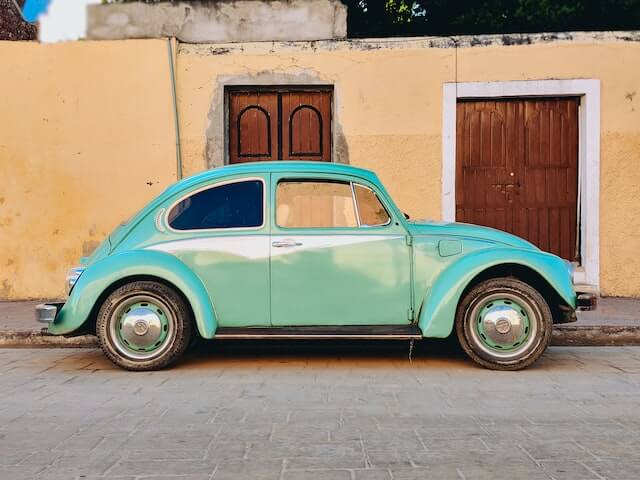

In [ ]:
image_file = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
prompt = "detect automobile"
image = Image.open(requests.get(image_file, stream=True).raw)
image

In [37]:
model_inputs = get_model_inputs_(processor, prompt, image_file, device)

In [ ]:
out = test_inference(model, model_inputs, device)
out

'<loc0338><loc0058><loc0795><loc0933> automobile'

In [ ]:
import re
import numpy as np


def parse_segments(detokenized_output: str) -> tuple[np.ndarray, np.ndarray]:
    # Remove spaces to simplify regex matching
    cleaned_output = detokenized_output.replace(" ", "")

    # Modified regex to handle the cleaned string
    matches = re.finditer(
        r"<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>",
        #         r'(?P<seg>(<seg\d\d\d>){16})',
        cleaned_output,
    )

    boxes, segs = [], []
    fmt_box = lambda x: float(x)  # / 1024.0

    for m in matches:
        d = m.groupdict()
        boxes.append(
            [fmt_box(d["y0"]), fmt_box(d["x0"]), fmt_box(d["y1"]), fmt_box(d["x1"])]
        )

    return np.array(boxes)


boxes = parse_segments(out)
boxes

array([[338.,  58., 795., 933.]])

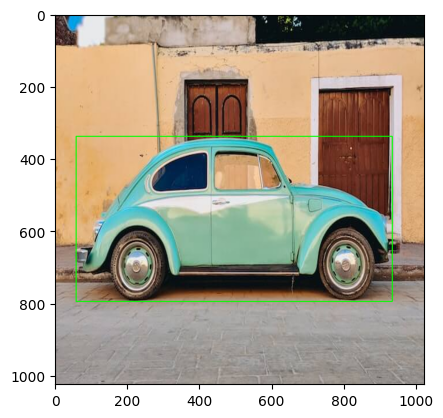

In [ ]:
import cv2

image = image.resize((1024, 1024))
image = np.array(image)
image_out = cv2.rectangle(
    image,
    (int(boxes[0][1]), int(boxes[0][0])),
    (int(boxes[0][3]), int(boxes[0][2])),
    (0, 255, 0),
    2,
)
plt.imshow(image_out)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.train()

# for epoch in range(2):
for idx, batch in enumerate(train_dataloader):
    outputs = model(**batch)
    loss = outputs.loss
    if idx % 25 == 0:
        print(f"Iter: {idx} Loss: {loss.item():.4f}")

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if idx == 200:
        break

Iter: 0 Loss: 3.0030
Iter: 25 Loss: 2.5391
Iter: 50 Loss: 2.2736
Iter: 75 Loss: 1.9342
Iter: 100 Loss: 2.0027
Iter: 125 Loss: 2.0840
Iter: 150 Loss: 3.0286
Iter: 175 Loss: 2.2175
Iter: 200 Loss: 1.6645


In [42]:
model.eval()

PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (fc1): Linear(in_features=1152, out_features=4304, bias=True)
              (f

In [ ]:
test_dataloader = DataLoader(
    val_dataset,
    collate_fn=collate_test_fn,
    batch_size=1,  # batch_size,
    shuffle=False,
)
test_batch = next(iter(test_dataloader))

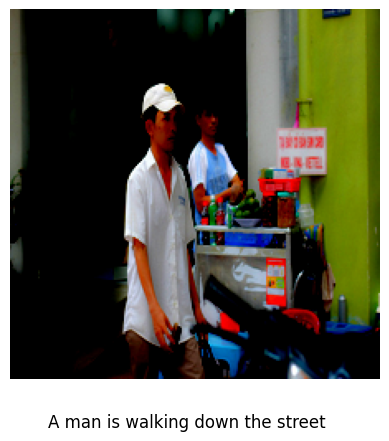

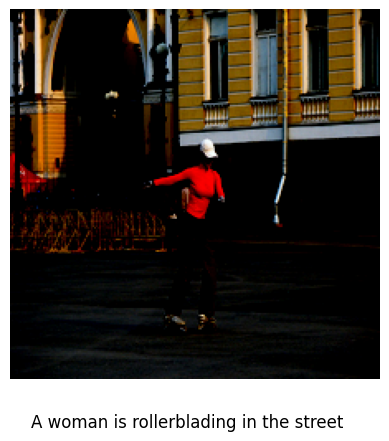

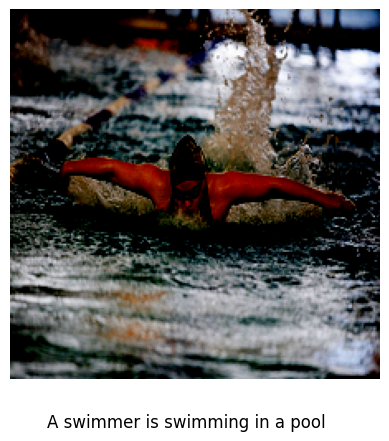

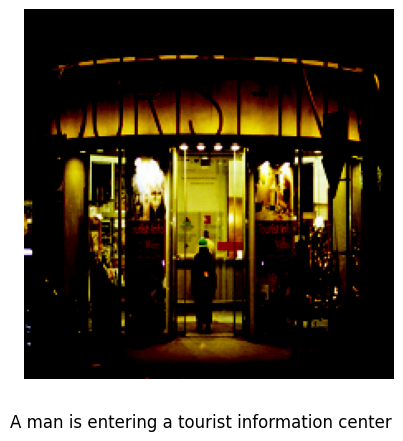

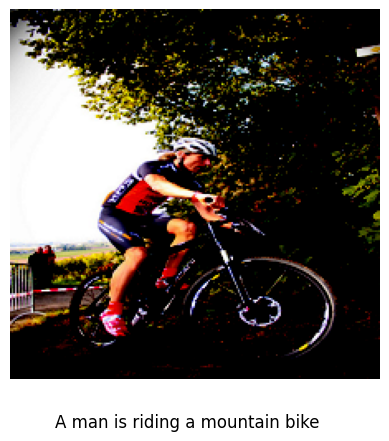

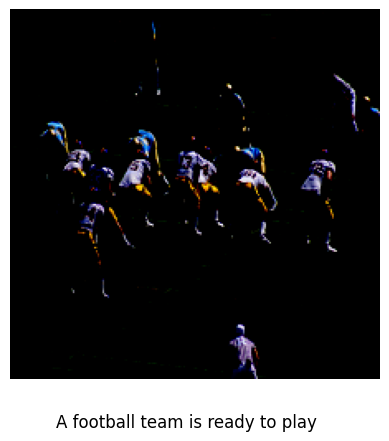

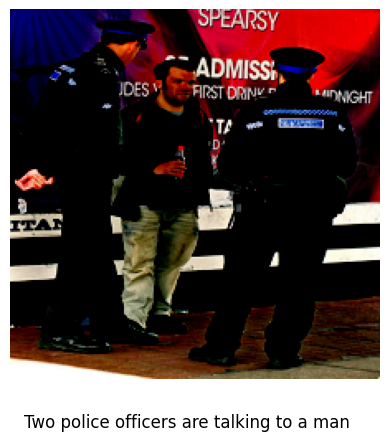

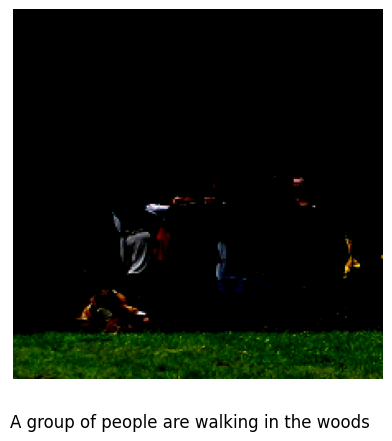

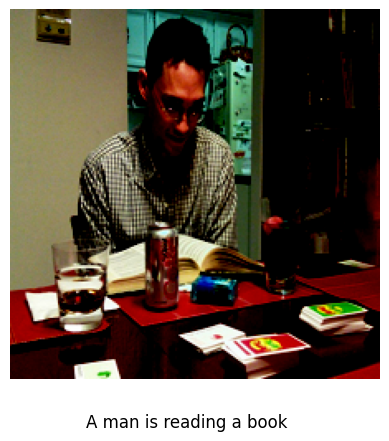

In [ ]:
for i, test_batch in enumerate(test_dataloader):
    index = 0
    output_text = test_inference(model, test_batch, device)
    plt.imshow(test_batch["pixel_values"][0].permute(1, 2, 0).cpu().to(torch.float32))
    plt.axis("off")
    plt.figtext(
        0.5, 0.01, output_text, wrap=True, horizontalalignment="center", fontsize=12
    )
    plt.show()
    if i == 8:
        break